### **Import Libraries**

In [1]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
from numpy import nan
from numpy import inf
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif,f_classif,chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import pickle

### **Loading the Static Dataset**

In [2]:
static_dataset= pd.read_csv("Static_dataset.csv")

### **Data Analysis**

In [3]:
# Display basic information about the dataset
dataset_info = static_dataset.info()
dataset_head = static_dataset.head()

dataset_info, dataset_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

(None,
   timestamp  FQDN_count  subdomain_length  upper  lower  numeric   entropy  \
 0   56:19.8          27                10      0     10       11  2.570417   
 1   07:23.9          27                10      0     10       11  2.767195   
 2   23:15.1          26                 9      0     10       10  2.742338   
 3   04:51.9          27                10      0     10       11  2.570417   
 4   12:44.0          15                 9      0     11        0  2.929439   
 
    special  labels  labels_max  labels_average longest_word    sld  len  \
 0        6       6           7        3.666667            2    192   14   
 1        6       6           7        3.666667            2    192   14   
 2        6       6           7        3.500000            2    192   13   
 3        6       6           7        3.666667            2    192   14   
 4        4       3           5        4.333333        local  local   15   
 
    subdomain  Target Attack  
 0          1              1

### **Data Analysis Function**

This function performs an extensive analysis on static dataset.
It includes the following analyses:
1. Correlation Matrix: Generates a heatmap of correlation coefficients between numerical features.
2. Distribution Analysis: Creates histograms for each numerical column to visualize data distributions.
3. Outlier Detection: Constructs boxplots for each numerical column to identify potential outliers.
4. Skewness Detection: Calculates and returns the skewness of each numerical column.

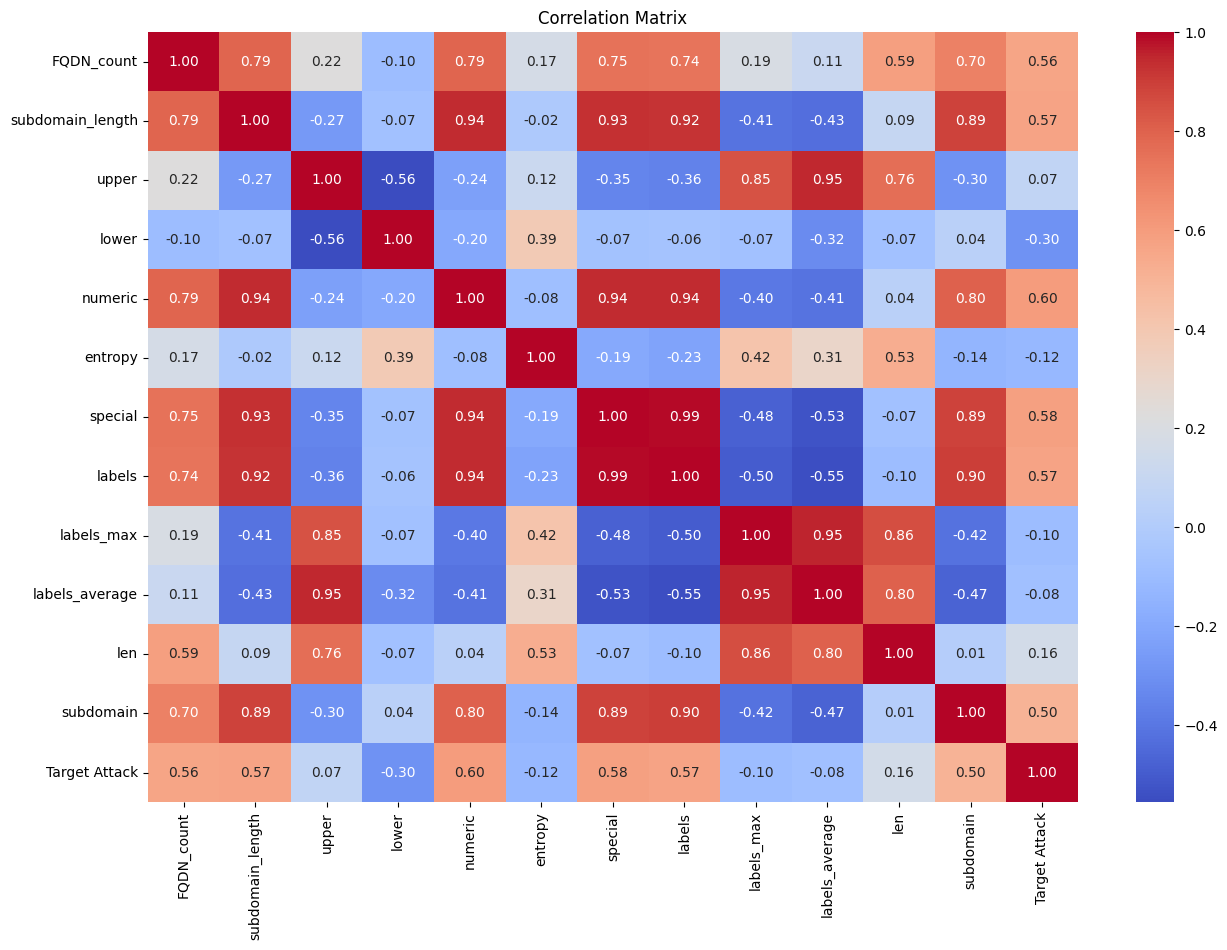

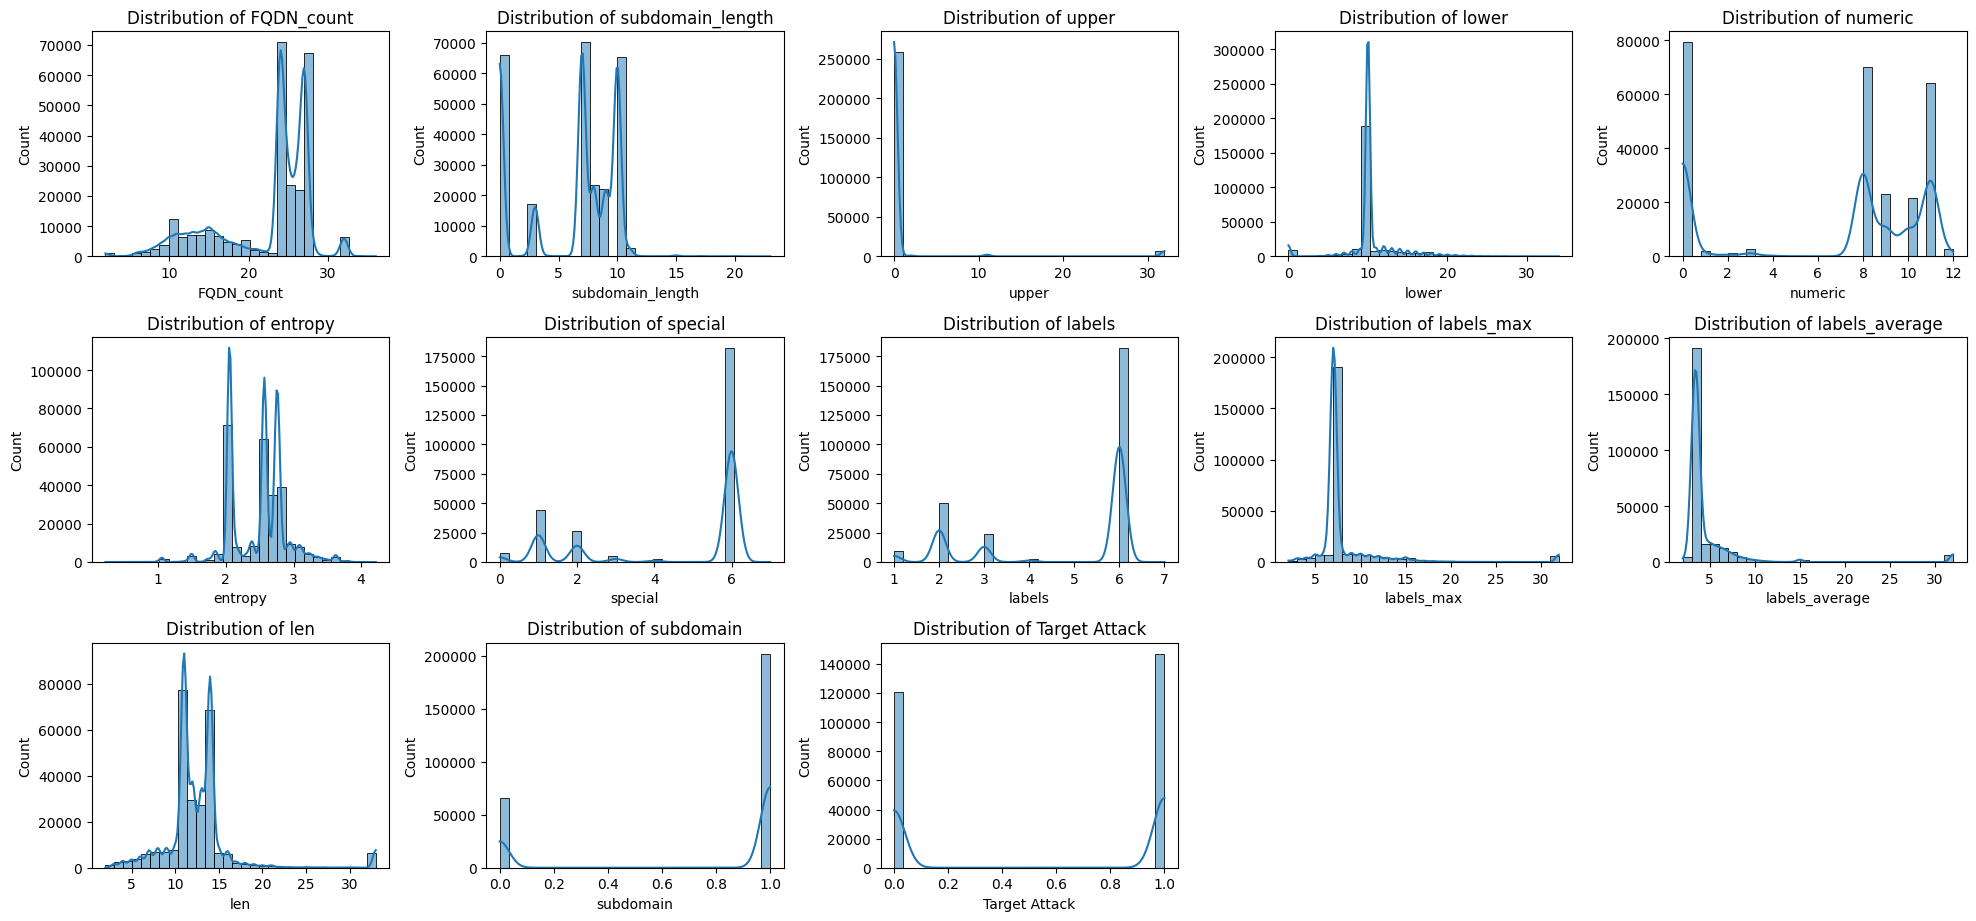

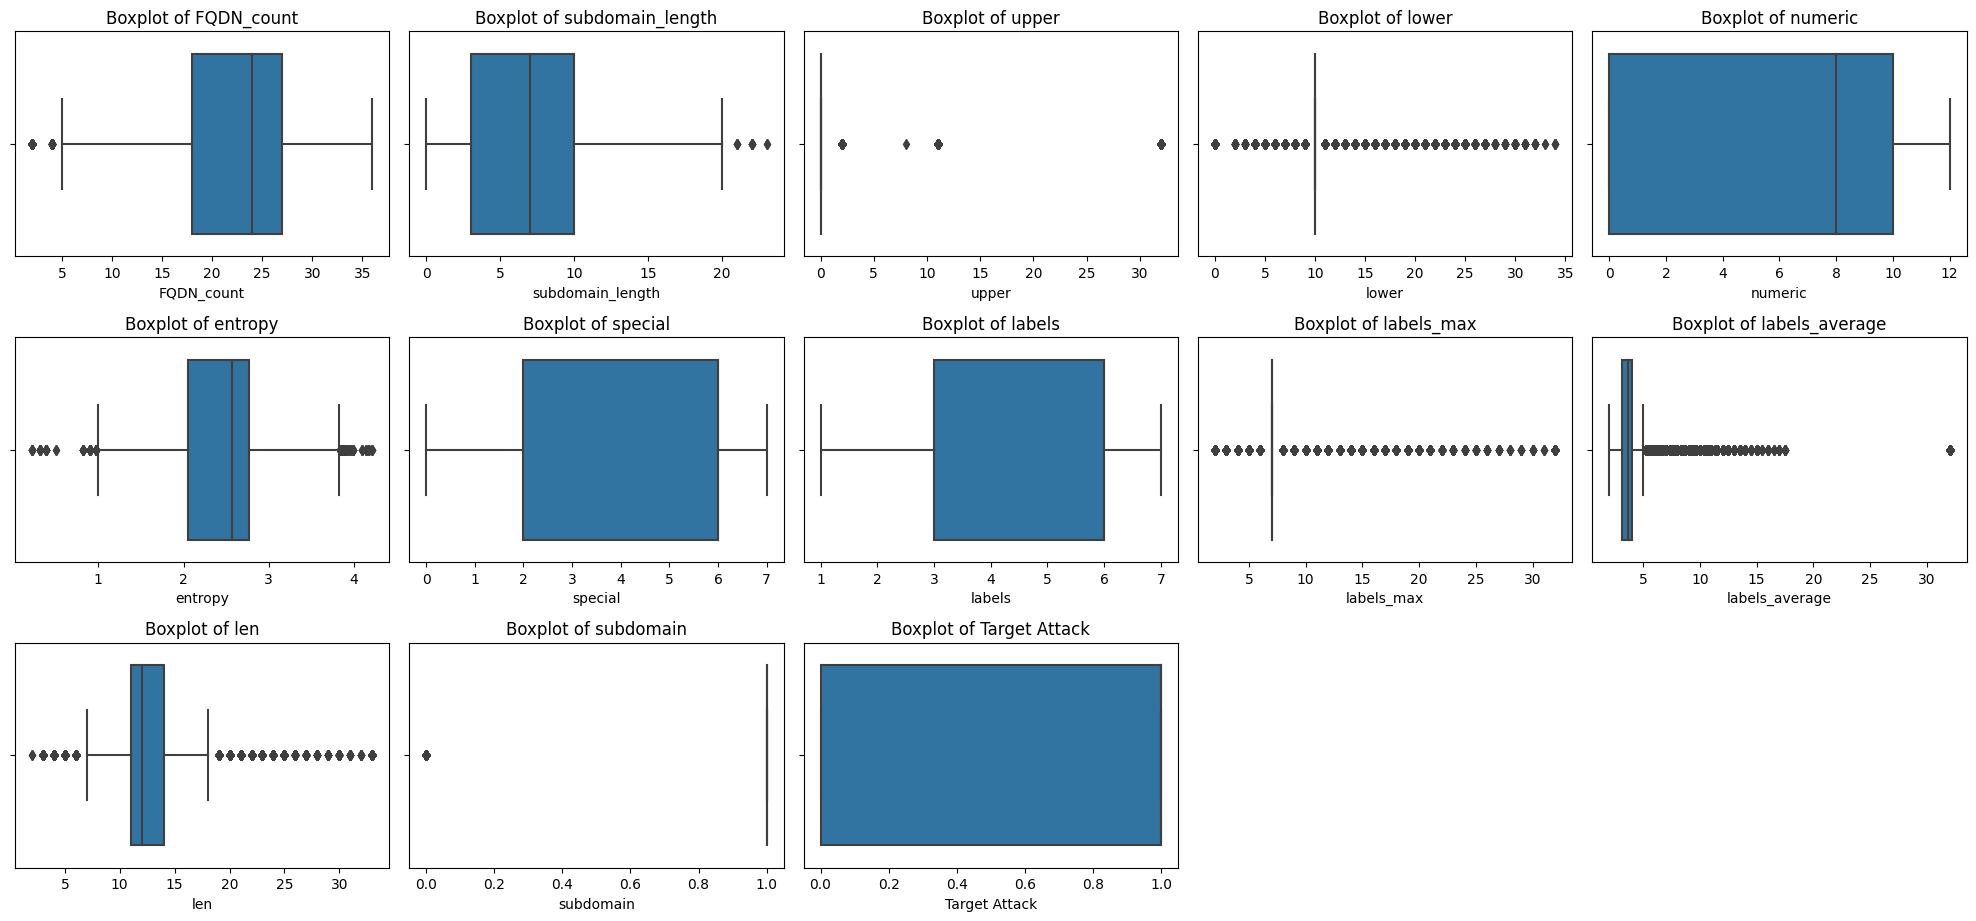

,Skewness
upper,5.988737
labels_average,5.087081
labels_max,3.979910
len,2.634801
lower,0.343449
entropy,-0.140156
Target Attack,-0.197046
subdomain_length,-0.590480
numeric,-0.594384
special,-0.902972


In [4]:
def data_analysis(df):

    numeric_cols = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_cols.corr()
    plt.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()

    # Distribution Analysis with Histograms
    num_columns = df.select_dtypes(include=['float64', 'int64']).columns
    plt.figure(figsize=(20, 15))
    for i, column in enumerate(num_columns, 1):
        plt.subplot(5, 5, i)
        sns.histplot(df[column], kde=True, bins=30)
        plt.title(f'Distribution of {column}')
    plt.tight_layout()
    plt.show()
    # Boxplot for Outliers
    plt.figure(figsize=(20, 15))
    for i, column in enumerate(num_columns, 1):
        plt.subplot(5, 5, i)
        sns.boxplot(x=df[column])
        plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()
    # Skewness Detection
    skewness = df[num_columns].skew().sort_values(ascending=False)
    skewness_df = pd.DataFrame({'Skewness': skewness})

    return skewness_df

# Applying the data analysis function with boxplot to the transformed dataset
skewness_summary_with_boxplot = data_analysis(static_dataset)
skewness_summary_with_boxplot


### **Target Variable Distribution**

The Target Attack variable, which is the target of our analysis, shows a relatively balanced distribution, with around 55% of the entries labeled as '1' (attack) and 45% labeled as '0' (no attack). This indicates that the dataset is not significantly imbalanced.

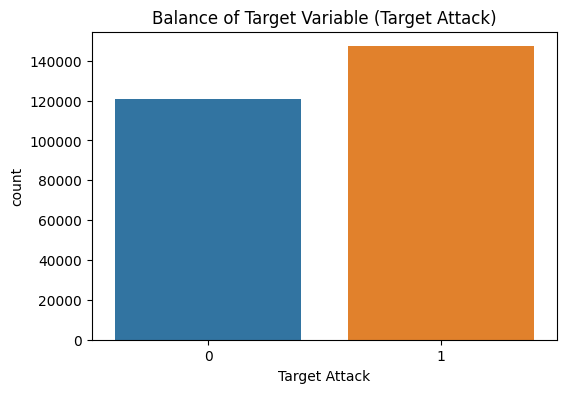

In [5]:
# Imbalance Check
plt.figure(figsize=(6, 4))
sns.countplot(x='Target Attack', data=static_dataset)
plt.title('Balance of Target Variable (Target Attack)')
plt.show()

### **Function for Feature Engineering and Data Cleaning**

 This function applies various preprocessing steps to the input DataFrame:
 1. Fills missing values in 'longest_word' with the most frequent value (mode).
 2. Converts 'timestamp' to a numerical value representing seconds. If the timestamp is a string in HH:MM:SS format, 
    it's converted to seconds. If the conversion fails or if it's already numeric, it's left as is.
 3. Applies a hashing transformation to 'longest_word' and 'sld' features, and mods the result by 10000 for a consistent range.

In [6]:
def feature_engineering_and_cleaning(df):
    # 1. Handling Missing Values
    mode_longest_word = df['longest_word'].mode()[0]
    df['longest_word'].fillna(mode_longest_word, inplace=True)

    # 2. Timestamp Transformation
    def convert_to_seconds(timestamp):
        minutes, seconds = map(float, timestamp.split(':'))
        return minutes * 60 + seconds

    df['timestamp'] = df['timestamp'].apply(convert_to_seconds)

    # 3. Hashing Transformation
    def hash_categorical_element(element):
        return hash(str(element)) % 10000

    df['longest_word'] = df['longest_word'].apply(hash_categorical_element)
    df['sld'] = df['sld'].apply(hash_categorical_element)

    return df

transformed_data = feature_engineering_and_cleaning(static_dataset)

# Displaying the transformed dataset
transformed_data.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,3379.8,27,10,0,10,11,2.570417,6,6,7,3.666667,7077,7192,14,1,1
1,443.9,27,10,0,10,11,2.767195,6,6,7,3.666667,7077,7192,14,1,1
2,1395.1,26,9,0,10,10,2.742338,6,6,7,3.500000,7077,7192,13,1,0
3,291.9,27,10,0,10,11,2.570417,6,6,7,3.666667,7077,7192,14,1,1
4,764.0,15,9,0,11,0,2.929439,4,3,5,4.333333,2221,2221,15,1,1


### **Applying different feature selection techniques**

In [7]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2

# Preparing the data for feature selection
X = static_dataset.drop('Target Attack', axis=1)
y = static_dataset['Target Attack']

#### **1. Mutual Information**

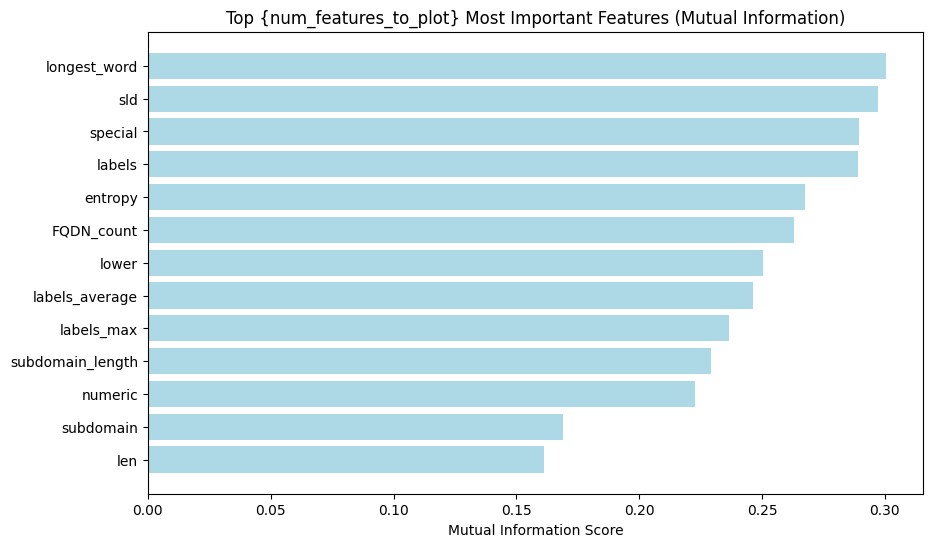

['longest_word',
 'sld',
 'special',
 'labels',
 'entropy',
 'FQDN_count',
 'lower',
 'labels_average',
 'labels_max',
 'subdomain_length']

In [8]:
# 1. Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k='all')
mi_selector.fit(X, y)
mi_scores = mi_selector.scores_

# Sort features by their scores
selected_feature_names = X.columns[mi_selector.get_support()]
sorted_feature_names_scores = sorted(zip(mi_scores, selected_feature_names), reverse=True)

# Extract names and scores of the top features
top_feature_names = [x for _, x in sorted_feature_names_scores]
top_feature_scores = [s for s, _ in sorted_feature_names_scores]

# Plotting the top features
num_features_to_plot = 13
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names[:num_features_to_plot], top_feature_scores[:num_features_to_plot], color='lightblue')
plt.xlabel('Mutual Information Score')
plt.title('Top {num_features_to_plot} Most Important Features (Mutual Information)')
plt.gca().invert_yaxis()
plt.show()
# Extracting top 10 features for printing
top_10_features_mutual = top_feature_names[:10]
top_10_features_mutual

#### **2. ANOVA F-test**

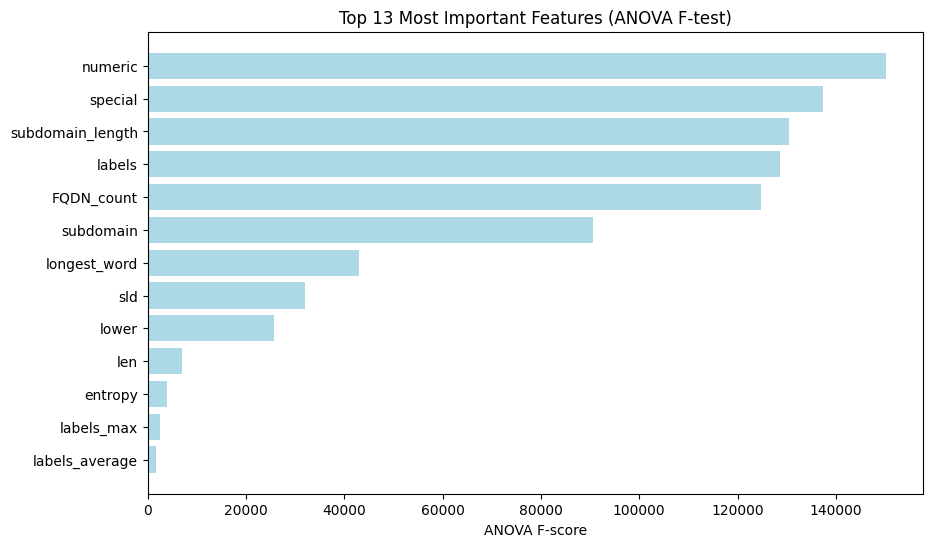

['numeric',
 'special',
 'subdomain_length',
 'labels',
 'FQDN_count',
 'subdomain',
 'longest_word',
 'sld',
 'lower',
 'len']

In [9]:
# 2. ANOVA F-test
anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X, y)
anova_scores = anova_selector.scores_
# Sort features by their scores
selected_feature_names = X.columns[anova_selector.get_support()]
sorted_feature_names_scores = sorted(zip(anova_scores, selected_feature_names), reverse=True)

# Extract names and scores of the top features
top_feature_names = [x for _, x in sorted_feature_names_scores]
top_f_scores = [s for s, _ in sorted_feature_names_scores]

# Plotting the top features
num_features_to_plot = 13
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names[:num_features_to_plot], top_f_scores[:num_features_to_plot], color='lightblue')
plt.xlabel('ANOVA F-score')
plt.title(f'Top {num_features_to_plot} Most Important Features (ANOVA F-test)')
plt.gca().invert_yaxis()
plt.show()

# Extracting top 10 features for printing
top_10_features_anova = top_feature_names[:10]
top_10_features_anova

#### **3. Chi-squared**

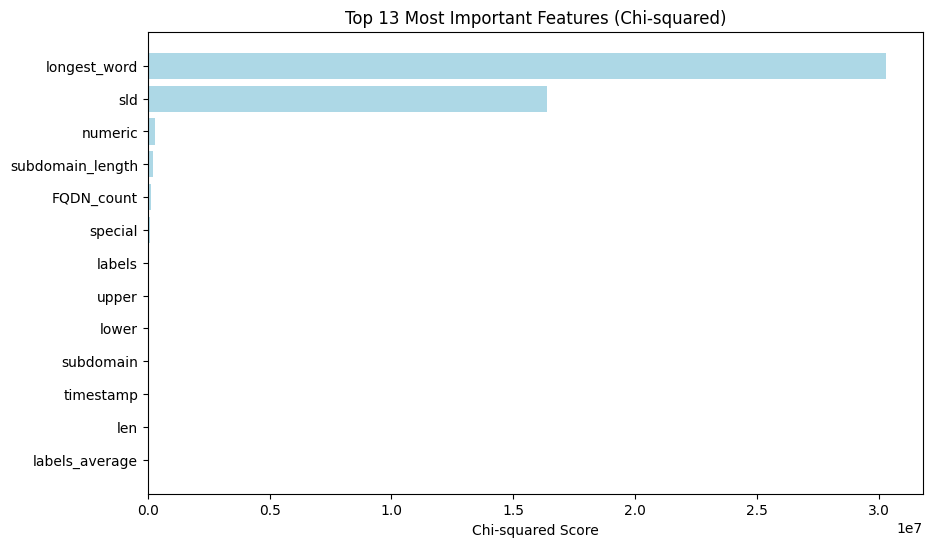

['longest_word',
 'sld',
 'numeric',
 'subdomain_length',
 'FQDN_count',
 'special',
 'labels',
 'upper',
 'lower',
 'subdomain']

In [10]:
# 3. Chi-squared
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X, y)
chi2_scores = chi2_selector.scores_

# Sort features by their scores
selected_feature_names = X.columns[chi2_selector.get_support()]
sorted_feature_names_scores = sorted(zip(chi2_scores, selected_feature_names), reverse=True)

# Extract names and scores of the top features
top_feature_names = [x for _, x in sorted_feature_names_scores]
top_chi2_scores = [s for s, _ in sorted_feature_names_scores]

# Plotting the top features
num_features_to_plot = 13
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names[:num_features_to_plot], top_chi2_scores[:num_features_to_plot], color='lightblue')
plt.xlabel('Chi-squared Score')
plt.title(f'Top {num_features_to_plot} Most Important Features (Chi-squared)')
plt.gca().invert_yaxis()
plt.show()

# Extracting top 10 features for printing
top_10_features_chi2 = top_feature_names[:10]
top_10_features_chi2


### **Creating a DataFrame to compare feature scores**

In [11]:
feature_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores,
    'ANOVA F-test': anova_scores,
    'Chi-squared': chi2_scores
}).set_index('Feature')

# Sorting the DataFrame by Mutual Information scores for better visualization
feature_scores_sorted = feature_scores_df.sort_values(by='Mutual Information', ascending=False)
feature_scores_sorted.head(10)  # Displaying the top 10 features


,Mutual Information,ANOVA F-test,Chi-squared
Feature,,,
longest_word,0.300461,43015.002036,3.030451e+07
sld,0.297079,32078.338275,1.637896e+07
special,0.289519,137390.213441,9.589290e+04
labels,0.288989,128620.678405,5.901955e+04
entropy,0.267387,3853.999101,2.540743e+02
FQDN_count,0.263009,124767.197802,1.375852e+05
lower,0.250402,25666.539455,2.315275e+04
labels_average,0.246141,1605.874838,6.951692e+03
labels_max,0.236579,2511.939679,5.879225e+03


### **Create a function to perform feature selection, model training, and evaluate F1-Score**

In [12]:
def evaluate_model_f1_score(X_train, X_test, y_train, y_test, feature_selection_method, model):
    # Feature selection
    k_best = SelectKBest(feature_selection_method, k=10)
    k_best.fit(X_train, y_train)
    selected_feature_names = X_train.columns[k_best.get_support()]
    X_train_selected = X_train[selected_feature_names]
    X_test_selected = X_test[selected_feature_names]

    # Train the specified model
    model.fit(X_train_selected, y_train)

    # Evaluate the model on the validation set using F1-Score
    y_pred_val = model.predict(X_test_selected)
    return f1_score(y_test, y_pred_val)

### **Normalize data using MinMaxScaler**

In [13]:
min_max_scaler = MinMaxScaler()
X_scaled_min_max = min_max_scaler.fit_transform(X)

# Convert scaled data back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled_min_max, columns=X.columns)


In [14]:
X_scaled_df.head(5)

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain
0,0.938859,0.735294,0.434783,0.0,0.294118,0.916667,0.588151,0.857143,0.833333,0.166667,0.055556,0.707842,0.719272,0.387097,1.0
1,0.123309,0.735294,0.434783,0.0,0.294118,0.916667,0.637374,0.857143,0.833333,0.166667,0.055556,0.707842,0.719272,0.387097,1.0
2,0.387539,0.705882,0.391304,0.0,0.294118,0.833333,0.631156,0.857143,0.833333,0.166667,0.050000,0.707842,0.719272,0.354839,1.0
3,0.081086,0.735294,0.434783,0.0,0.294118,0.916667,0.588151,0.857143,0.833333,0.166667,0.055556,0.707842,0.719272,0.387097,1.0
4,0.212228,0.382353,0.391304,0.0,0.323529,0.000000,0.677959,0.571429,0.333333,0.100000,0.077778,0.222144,0.222122,0.419355,1.0


### **Splitting the data into training and validation sets**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=42)

### **Evaluate Random Forest and Logistic Regression models with different feature selection techniques**

In [16]:
rf_mutual_info_f1 = evaluate_model_f1_score(X_train, X_test, y_train, y_test, mutual_info_classif, RandomForestClassifier(random_state=42))
rf_chi2_f1 = evaluate_model_f1_score(X_train, X_test, y_train, y_test, chi2, RandomForestClassifier(random_state=42))
rf_anova_f1 = evaluate_model_f1_score(X_train, X_test, y_train, y_test, f_classif, RandomForestClassifier(random_state=42))

In [17]:
lr_mutual_info_f1 = evaluate_model_f1_score(X_train, X_test, y_train, y_test, mutual_info_classif, LogisticRegression(max_iter=1000, random_state=42))
lr_chi2_f1 = evaluate_model_f1_score(X_train, X_test, y_train, y_test, chi2, LogisticRegression(max_iter=1000, random_state=42))
lr_anova_f1 = evaluate_model_f1_score(X_train, X_test, y_train, y_test, f_classif, LogisticRegression(max_iter=1000, random_state=42))

### **Creating DataFrames for F1-Score comparison**

In [18]:
rf_f1_scores = pd.DataFrame({
    'Feature Selection Method': ['Mutual Info', 'Chi-squared', 'ANOVA'],
    'F1-Score': [rf_mutual_info_f1, rf_chi2_f1, rf_anova_f1],
    'Model': 'Random Forest'
})

In [19]:
lr_f1_scores = pd.DataFrame({
    'Feature Selection Method': ['Mutual Info', 'Chi-squared', 'ANOVA'],
    'F1-Score': [lr_mutual_info_f1, lr_chi2_f1, lr_anova_f1],
    'Model': 'Logistic Regression'
})

### **The visualization of F1-scores for Random Forest model using different feature selection methods**

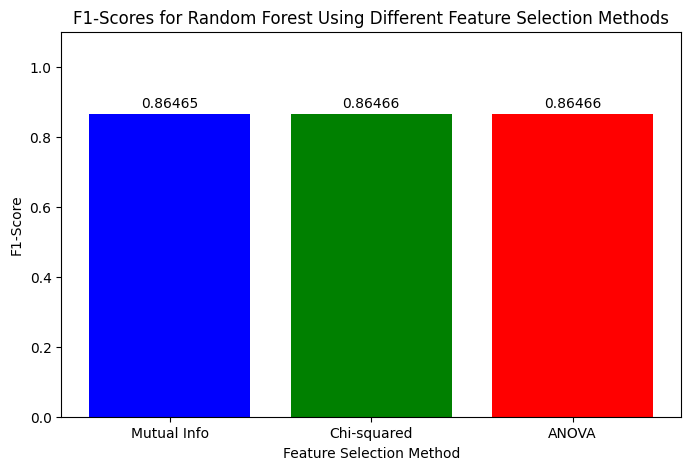

In [20]:
plt.figure(figsize=(8, 5))
bars = plt.bar(rf_f1_scores['Feature Selection Method'], rf_f1_scores['F1-Score'], color=['blue', 'green', 'red'])

# Adding the text on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 5), ha='center', va='bottom')

plt.xlabel('Feature Selection Method')
plt.ylabel('F1-Score')
plt.title('F1-Scores for Random Forest Using Different Feature Selection Methods')
plt.ylim(0, 1.1)
plt.show()

### **The visualization of F1-scores for Logistic Regression model using different feature selection methods**

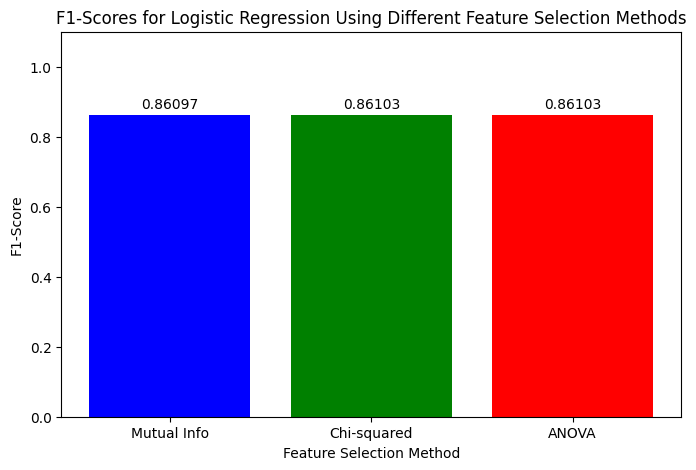

In [21]:
plt.figure(figsize=(8, 5))
bars = plt.bar(lr_f1_scores['Feature Selection Method'], lr_f1_scores['F1-Score'], color=['blue', 'green', 'red'])

# Adding the text on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 5), ha='center', va='bottom')

plt.xlabel('Feature Selection Method')
plt.ylabel('F1-Score')
plt.title('F1-Scores for Logistic Regression Using Different Feature Selection Methods')
plt.ylim(0, 1.1)
plt.show()

### **Determining the best version of each model**

In [22]:
best_rf_method = rf_f1_scores.sort_values(by='F1-Score', ascending=False).iloc[0]['Feature Selection Method']
best_lr_method = lr_f1_scores.sort_values(by='F1-Score', ascending=False).iloc[0]['Feature Selection Method']

# Final comparison between the best Random Forest and Logistic Regression models
best_rf_f1_score = rf_f1_scores[rf_f1_scores['Feature Selection Method'] == best_rf_method]['F1-Score'].iloc[0]
best_lr_f1_score = lr_f1_scores[lr_f1_scores['Feature Selection Method'] == best_lr_method]['F1-Score'].iloc[0]

print(f"Best Random Forest used the {best_rf_method} with F1-Score: {round(best_rf_f1_score,5)}")
print(f"Best Logistic Regression used the {best_lr_method} with F1-Score: {round(best_lr_f1_score,5)}")

Best Random Forest used the Chi-squared with F1-Score: 0.86466
Best Logistic Regression used the Chi-squared with F1-Score: 0.86103


### **Plot a bar chart for the overall best model F1-scores of the Random Forest and Logistic Regression models**

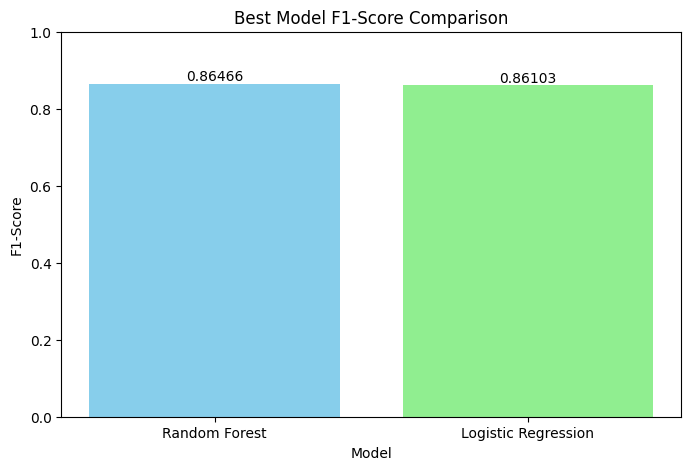

In [23]:
plt.figure(figsize=(8, 5))
bars = plt.bar(['Random Forest', 'Logistic Regression'], [best_rf_f1_score, best_lr_f1_score], color=['skyblue', 'lightgreen'])
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('Best Model F1-Score Comparison')
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 5), ha='center', va='bottom')

plt.show()

### **Displaying the overall best model**

In [24]:
overall_best = 'Random Forest' if best_rf_f1_score > best_lr_f1_score else 'Logistic Regression'
print(f"The overall best model is {overall_best} used the {best_rf_method} with F1-Score: {max(best_rf_f1_score, best_lr_f1_score):.3f}")


The overall best model is Random Forest used the Chi-squared with F1-Score: 0.865


### **Fine-tune the best model and save it as a pipeline**

In [41]:
selected_features = ['longest_word','sld','numeric','subdomain_length','FQDN_count','special','labels','upper','lower','subdomain']
X_selected = static_dataset[selected_features]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

best_hyperparams = {
    'n_estimators': 100,  
    'max_depth': 20,      
    'min_samples_split': 2,  
    'min_samples_leaf': 1,   
    'bootstrap': True,       
    'criterion': 'entropy'      
}

# Create a pipeline with a scaler and the RandomForestClassifier with the best hyperparameters
fitted_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('randomforestclassifier', RandomForestClassifier(**best_hyperparams, random_state=42))
])

# Fit the pipeline on the full training data
fitted_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=20,
                                        random_state=42))])

### **Evaluate the Model**

In [43]:
y_pred = fitted_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"F1 Score of the best Random Forest model after fine-tuning:", round(f1,3))

F1 Score of the best Random Forest model after fine-tuning: 0.865


#### **Model Saving**

In [44]:
with open('best_rf_model_chi.pkl', 'wb') as file:
    pickle.dump(fitted_pipeline, file)